# Titanic Survivor Prediction

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

### Load dataset

In [3]:
df_train = pd.read_csv('../../datasets/titanic/train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Clean-Up dataset

We only need to keep the following columns:
   - PassengerId => Id
   - Survived => Label
   - Pclass
   - Sex
   - Age => Vizualize and Bucketize accordingly
   - SibSp: Number of siblings and/or Spouse on board
   - Parch: Number of Parent and/or Children on board
   - Embarked: One-Hot encode

In [4]:
df_train = df_train.drop(columns=[ 'PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin'])
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S


In [4]:
df_train.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Embarked     object
dtype: object

In [5]:
df_train['Age'] = pd.cut(df_train['Age'], bins=6, labels=False).astype('category')

<Axes: >

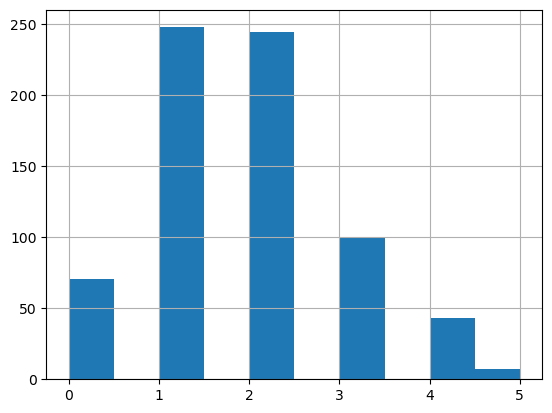

In [6]:
df_train['Age'].hist()

<Axes: >

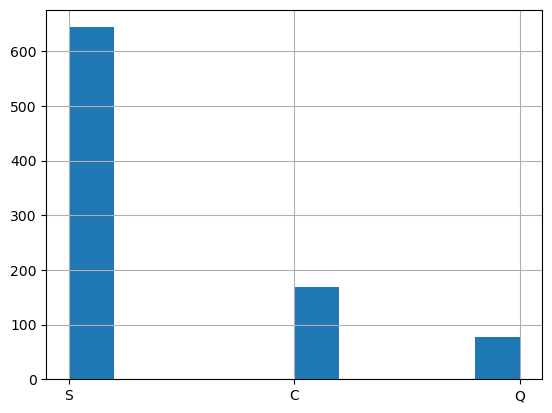

In [73]:
df_train['Embarked'].hist()

In [7]:
df_train['Sex'] = df_train['Sex'].map( {'female': 0, 'male': 1} ).astype('category') 
df_train['Embarked'] = df_train['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype('category') 


In [8]:
print(df_train.head())
print(df_train.dtypes)


   Survived  Pclass Sex  Age  SibSp  Parch Embarked
0         0       3   1  1.0      1      0      0.0
1         1       1   0  2.0      1      0      1.0
2         1       3   0  1.0      0      0      0.0
3         1       1   0  2.0      1      0      0.0
4         0       3   1  2.0      0      0      0.0
Survived       int64
Pclass         int64
Sex         category
Age         category
SibSp          int64
Parch          int64
Embarked    category
dtype: object


### Do the same to the test set

In [8]:
df_test = pd.read_csv("../../datasets/titanic/test.csv")
df_test = df_test.drop(columns=[ 'PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin'])
df_test['Age'] = pd.cut(df_test['Age'], bins=4, labels=False).astype('category')
df_test['Sex'] = df_test['Sex'].map( {'female': 0, 'male': 1} ).astype('category') 
df_test['Embarked'] = df_test['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype('category') 
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked
0,3,1,1.0,0,0,2
1,3,0,2.0,1,0,0
2,2,1,3.0,0,0,2
3,3,1,1.0,0,0,0
4,3,0,1.0,1,1,0


### Prepare Model training

In [9]:
inputs_train = df_train.drop(columns=['Survived'])
labels_train = df_train["Survived"]
inputs_test = df_test

<Axes: >

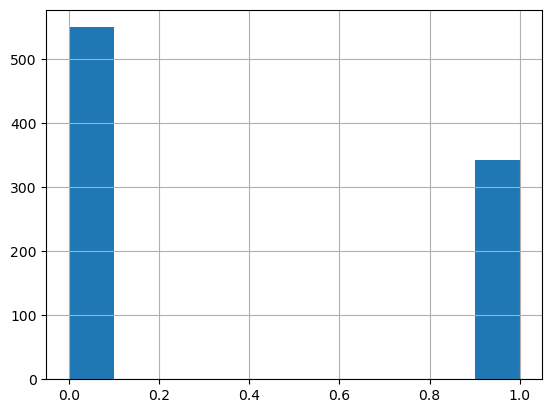

In [11]:
labels_train.hist()

In [79]:
model = HistGradientBoostingClassifier(loss="log_loss",
                                        learning_rate=0.1, 
                                        max_iter=50, 
                                        max_depth= 3,
                                        categorical_features=['Sex', 'Age', 'Embarked'],
                                        min_samples_leaf=10,
                                        l2_regularization=0.01,
                                        )
model.fit(inputs_train, labels_train)

HistGradientBoostingClassifier(categorical_features=['Sex', 'Age', 'Embarked'],
                               l2_regularization=0.01, max_depth=3, max_iter=50,
                               min_samples_leaf=10)

In [80]:
model.score(inputs_train, labels_train)

0.8338945005611672

### Model fine-tuning

Let's do a proper gridsearch cross validation

In [81]:
from sklearn.model_selection import GridSearchCV, KFold

In [82]:
model = HistGradientBoostingClassifier(categorical_features=['Sex', 'Age', 'Embarked'])
param_grids = {
        "max_iter": [10, 20, 50, 100, 300, 500],
        "learning_rate": [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3],
        "max_depth": [1,3,5,10],
        "l2_regularization": [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3],
        "min_samples_leaf": [1,3,5,10]
}
cv = KFold(n_splits=3, shuffle=True, random_state=123)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grids,
    return_train_score=True,
    cv=cv,
    verbose=1
).fit(inputs_train, labels_train)
result = pd.DataFrame(grid_search.cv_results_)
result

Fitting 3 folds for each of 6144 candidates, totalling 18432 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_l2_regularization,param_learning_rate,param_max_depth,param_max_iter,param_min_samples_leaf,params,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.007556,0.000710,0.001917,0.000295,0.001,0.001,1,10,1,"{'l2_regularization': 0.001, 'learning_rate': ...",...,0.653199,0.572391,0.616162,0.033332,4763,0.612795,0.597643,0.638047,0.616162,0.016666
1,0.005399,0.000646,0.001268,0.000165,0.001,0.001,1,10,3,"{'l2_regularization': 0.001, 'learning_rate': ...",...,0.653199,0.572391,0.616162,0.033332,4763,0.612795,0.597643,0.638047,0.616162,0.016666
2,0.003734,0.000568,0.000876,0.000168,0.001,0.001,1,10,5,"{'l2_regularization': 0.001, 'learning_rate': ...",...,0.653199,0.572391,0.616162,0.033332,4763,0.612795,0.597643,0.638047,0.616162,0.016666
3,0.004129,0.001390,0.000908,0.000205,0.001,0.001,1,10,10,"{'l2_regularization': 0.001, 'learning_rate': ...",...,0.653199,0.572391,0.616162,0.033332,4763,0.612795,0.597643,0.638047,0.616162,0.016666
4,0.005335,0.000669,0.001288,0.000583,0.001,0.001,1,20,1,"{'l2_regularization': 0.001, 'learning_rate': ...",...,0.653199,0.572391,0.616162,0.033332,4763,0.612795,0.597643,0.638047,0.616162,0.016666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6139,0.310668,0.130580,0.006156,0.000520,3,3,10,300,10,"{'l2_regularization': 3, 'learning_rate': 3, '...",...,0.767677,0.784512,0.762065,0.020997,4399,0.762626,0.836700,0.819865,0.806397,0.031705
6140,0.809063,0.281966,0.009490,0.000771,3,3,10,500,1,"{'l2_regularization': 3, 'learning_rate': 3, '...",...,0.606061,0.696970,0.692480,0.068802,4523,0.826599,0.755892,0.809764,0.797419,0.030157
6141,0.759372,0.359425,0.010358,0.001263,3,3,10,500,3,"{'l2_regularization': 3, 'learning_rate': 3, '...",...,0.754209,0.723906,0.750842,0.020756,4423,0.818182,0.865320,0.808081,0.830527,0.024945
6142,0.550988,0.313517,0.009235,0.000742,3,3,10,500,5,"{'l2_regularization': 3, 'learning_rate': 3, '...",...,0.747475,0.686869,0.741863,0.042796,4432,0.831650,0.821549,0.786195,0.813131,0.019488


In [83]:
print("Best Params:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
best_model = grid_search.best_estimator_

Best Params: {'l2_regularization': 0.01, 'learning_rate': 0.01, 'max_depth': 3, 'max_iter': 500, 'min_samples_leaf': 5}
Best Score: 0.829405162738496


### Retrain model

In [10]:
best_model = HistGradientBoostingClassifier(loss="log_loss",
                                        learning_rate=0.01, 
                                        max_iter=500, 
                                        max_depth= 3,
                                        categorical_features=['Sex', 'Age', 'Embarked'],
                                        min_samples_leaf=5,
                                        l2_regularization=0.01,
                                        )
best_model.fit(inputs_train, labels_train)

HistGradientBoostingClassifier(categorical_features=['Sex', 'Age', 'Embarked'],
                               l2_regularization=0.01, learning_rate=0.01,
                               max_depth=3, max_iter=500, min_samples_leaf=5)

In [11]:
best_model.score(inputs_train, labels_train)

0.8338945005611672

In [12]:
Y_test = best_model.predict(inputs_test)

In [85]:
results = pd.read_csv('../../datasets/titanic/test.csv')
results.insert(1, 'Survived', Y_test)
results = results[['PassengerId', 'Survived']]
results.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Survived'}>]], dtype=object)

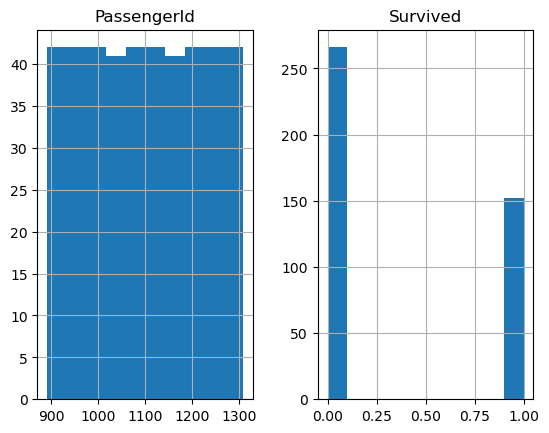

In [86]:
results.hist()

In [87]:
results.to_csv("./titanic_predictions.csv", encoding='utf-8', index=False)